In [ ]:
import sys
sys.path.append('../')

import torch
import pandas as pd
from scipy.sparse.linalg import spsolve
from tqdm import tqdm

from fit_heat_multibc import C2DS, C5DS
from UniformICD import UniformFVM
from Problems.BlockSourceProblem import BlockSourceProblem
from utils import layout2csv, ChipLayout
from MyPlot import *
from BaseTester import BaseTester
from scipy.sparse import load_npz


In [ ]:
class HeatTester(BaseTester):
	def __init__(self,  **kwargs):
		super().__init__(**kwargs)
		self.boundary_gap = 0.001
		self.chip_gap = 0.001
		self.mesh()
		# self.gen_linsys()

		self.h = 0.1 / self.GridSize
	
	def l2(self, pre, ans):
		return np.sqrt(((pre - ans)**2 * self.h**2).sum())
			
	# def gen_layouts(self, DataN):
	# 	df = layout2csv(DataN, self.area, self.GridSize, self.boundary_gap, self.chip_gap)
	# 	layouts = []

	# 	for _, data in df.groupby("idx"):
	# 		info = data.values[:, 1:]
	# 		chips_layout = ChipLayout(info)
	# 		layout = chips_layout(self.xx, self.yy)
	# 		for i in range(3):
	# 			layouts.append(torch.from_numpy(layout))
	# 	layouts = torch.stack(layouts, dim=0)
	# 	return layouts

	# def gen_linsys(self):
	# 	self.A, self.B = [], []
	# 	for bd_case in [0, 1, 2]:
	# 		problem = BlockSourceProblem(
	# 				None, 
	# 				bd_case, 298, 
	# 				self.GridSize, 
	# 				self.area
	# 		)

	# 		solver = UniformFVM(
	# 			self.area, 
	# 			self.GridSize, 
	# 			self.GridSize, 
	# 			problem
	# 		)
			
	# 		A, b = solver.get_A()
			
	# 		self.B.append(b)
	# 		self.A.append(A)

	def init_test_ds(self, DataN, bd_case=[0, 1, 2]):
		layouts = np.load(f'./TestData/GridSize-{self.GridSize}/F.npy')[:DataN]
		layouts = np.repeat(layouts, 3, axis=0)
		layouts = torch.from_numpy(layouts)
		refs = []
		for case in bd_case:
			refs.append(np.load(f'./TestData/GridSize-{self.GridSize}/case-{case+1}/U.npy')[:DataN])
			
		bd_cases = bd_case * DataN
		match self.kwargs['net_kwargs']['in_channels']:
			case 2:
				ds = C2DS(
					self.area, 
					self.GridSize, 
					layouts, self.dtype, self.device, bd_cases
				)
			case 5:
				ds = C5DS(
					self.area, 
					self.GridSize, 
					layouts, self.dtype, self.device, bd_cases
				)
		self.ds = ds
		self.refs = refs

	def test(self, exp_name, DataN, best_or_last):
		self.load_kwargs(exp_name)
		self.init_test_ds(DataN)
		self.load_ckpt(best_or_last, exp_name)

		df = {
			# 'id': [],
			'l2_bd1': [],
			'l2_bd2': [],
			'l2_bd3': []

		}

		with torch.no_grad():
			for i in tqdm(range(DataN)):
				errors = []
				for j in range(3):
					data, layout, boundary, bd_case = self.ds[i*3 + j]
					data = data[None, ...]

					if 'Plus298' in exp_name:
						pre = self.net(data) + 298
					else:
						pre = self.net(data) 
						
					ans = self.refs[bd_case][i]
					l2 = self.l2(pre.cpu().numpy(), ans)
					errors.append(l2)
					df[f'l2_bd{j+1}'].append(errors[j])
					
				# if  max(errors) < 0.015:
				# 	for j in range(3):
				# 		self.save_img(f"{self.img_save_path}/{exp_name}/TestCase-{i}-{j}", pres[j], anss[j], boundarys[j], layouts[j])

		df = pd.DataFrame(df)
		p = Path(f"{self.img_save_path}/{exp_name}")
		if not p.is_dir():
			p.mkdir(parents=True)
		df.to_csv(f"{self.img_save_path}/{exp_name}/l2.csv", index=False)
		
	def save_img(self, path, pre, ans, boundary, Force):
		p = Path(path)
		if not p.is_dir():
			p.mkdir(parents=True)

		pre = pre.cpu().numpy().reshape(self.GridSize, self.GridSize)
		ans = ans.reshape(self.GridSize, self.GridSize)
		boundary = boundary.cpu().numpy().reshape(self.GridSize, self.GridSize)
		Force = Force.cpu().numpy().reshape(self.GridSize, self.GridSize)

		# plt.rcParams['font.size'] 			= 14  # Default font size
		# plt.rcParams['axes.titlesize'] 		= 18  # Font size for axes titles
		# plt.rcParams['axes.labelsize'] 		= 16  # Font size for axes labels
		# plt.rcParams['xtick.labelsize'] 	= 12  # Font size for x-tick labels
		# plt.rcParams['ytick.labelsize'] 	= 12  # Font size for y-tick labels
		# plt.rcParams['legend.fontsize'] 	= 20  # Font size for legend
		# plt.rcParams['figure.titlesize'] 	= 20  # Font size for figure title

		save_surf(path, pre, self.xx, self.yy, 'surf_pre', cmap=cm.coolwarm)
		save_surf(path, ans, self.xx, self.yy, 'surf_ref', cmap=cm.coolwarm)
		save_ctf(path, pre, ans, self.xx, self.yy, cmap=cm.coolwarm)
		save_contour(path, pre, ans, self.xx, self.yy, levels=None)
		save_img_force(path, Force, 'force', cmap=cm.coolwarm)
		save_img_force(path, boundary, 'boundary', cmap=cm.coolwarm)

In [ ]:
heat_tester = HeatTester(
    GridSize=128,
    area=((0, 0), (0.1, 0.1)),
    ckpt_save_path=f'model_save',
    hyper_parameters_save_path = f'hyper_parameters', 
    img_save_path = f'./images', 
    device='cuda',
    dtype=torch.float,
    )

# exp_name='JJQC2-ResBottleNeck-4#4#6#6#8-4#4#6#6#8-2-layer-max-reflect-128-jac-5-10000-5'
exp_name = 'VUnetReluC2'
best_or_last='last'

DataN = 2000
heat_tester.test(exp_name, DataN, best_or_last)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# df = pd.read_csv('./JJQC2-ResBottleNeck-4#4#6#6#8-4#4#6#6#8-2-layer-max-reflect-128-jac-5-10000-5.csv')
df = pd.read_csv('./l2.csv')

for i in [1, 2, 3]:
	fig = plt.figure(figsize=(10, 6))  # Set the figure size
	plt.rcParams['font.size'] 			= 18  # Default font size
		# plt.rcParams['axes.titlesize'] 		= 18  # Font size for axes titles
		# plt.rcParams['axes.labelsize'] 		= 16  # Font size for axes labels
		# plt.rcParams['xtick.labelsize'] 	= 12  # Font size for x-tick labels
		# plt.rcParams['ytick.labelsize'] 	= 12  # Font size for y-tick labels
		# plt.rcParams['legend.fontsize'] 	= 20  # Font size for legend
		# plt.rcParams['figure.titlesize'] 	= 20  # Font size for figure title
	data = np.log10(df[f'l2_bd{i}'])
	ax = sns.histplot(
		# df[f'l2_bd{i}'].rolling(window=5).mean(),b
		data,
		bins=50,  # Number of bins
		kde=True,  # Add KDE (Kernel Density Estimate)
		stat='probability',  # Normalize the histogram
		color='crimson',  # Color of the bars
		edgecolor='black'  # Color of the edges,
		
	)
	print(df[f'l2_bd{i}'].mean())

	# Customization
	plt.title(f'$BC_{i}$')  # Title of the plot
	plt.xticks(np.linspace(data.min(), data.max(), 6))
	plt.xlabel('$Log_{L_2}$')  # X-axis label
	plt.ylabel('Probability')  # Y-axis label
	plt.grid(True)  # Show grid lines
	plt.show()
	fig.savefig(f'./test_bd{i}.png')
	plt.close()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# df = pd.read_csv('./JJQC2-ResBottleNeck-4#4#6#6#8-4#4#6#6#8-2-layer-max-reflect-128-jac-5-10000-5.csv')
df = pd.read_csv('l2.csv')
all_data = pd.concat([df[f'l2_bd{i}'] for i in [1, 2, 3]]).reset_index(drop=True)
df1 = pd.DataFrame({'all': all_data})
print(df1.shape)

fig = plt.figure(figsize=(10, 6))  # Set the figure size
plt.rcParams['font.size'] = 18  # Default font size
data = np.log10(df1['all'])
sns.histplot(
	data,
	bins=50,  # Number of bins
	kde=True,  # Add KDE (Kernel Density Estimate)
	stat='probability',  # Normalize the histogram
	color='navy',  # Color of the bars
	edgecolor='black'  # Color of the edges
)
print(df1['all'].mean())

# Customization
plt.title('$\mathcal{P}_{BC}$')  # Title of the plot
plt.xticks(np.linspace(data.min(), data.max(), 7))
plt.xlabel('$Log_{L_2}$')  # X-axis label
plt.ylabel('Probability')  # Y-axis label
plt.grid(True)  # Show grid lines
plt.show()
fig.savefig(f'./all_test.png')
plt.close()

In [ ]:
import torch
from torchinfo import summary
# import torcheval
import sys
sys.path.append('../')

from SegModel import CNN
net_kwargs={
		'model_name': 'UNet',
		'Block': "ResBottleNeck",
		'planes':6,
		'in_channels':2,
		'classes':1,
		'GridSize':128,
		'layer_nums':   [2, 2, 4, 4, 6],
		'factor':2,
		'norm_method': 'layer',
		'pool_method':'max',
		'padding':'same',
		'padding_mode':'reflect',
		'end_padding':'same',
		'end_padding_mode':'reflect',
		'act':'relu'
	}
# ckpt = torch.load('model_save/128/UNetRelu-C2-float/last.pt', map_location='cpu', weights_only=True)
net_kwargs.pop('model_name')
net = CNN(name='UNet', kwargs=net_kwargs, dtype=torch.float, device='cuda')
summary(net)

1.9073504518019035e-05
2.9144371469980387e-05


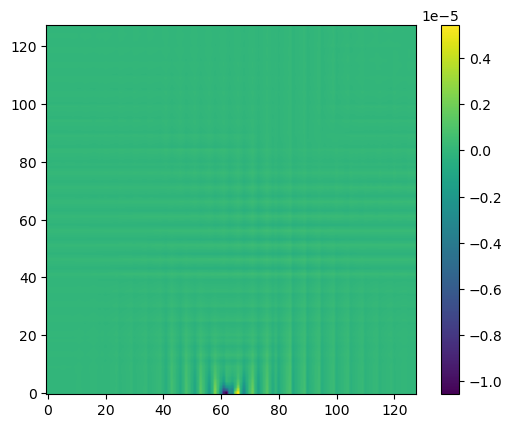

In [ ]:
import torch
import numpy as np
import scipy.sparse as sp
from fit_heat_multibc import *

device = torch.device('cuda')
dtype = torch.double
gridsize = 128
h = 0.1/gridsize
batch_size = 1
max_iter = 10

case_id = 2
F = np.load(f'./TestData/GridSize-128/F.npy')[0].flatten()
u = np.load(f'./TestData/GridSize-128/case-{case_id}/U.npy')[0].flatten()
A = sp.load_npz(f'./TestData/GridSize-128/case-{case_id}/A.npz').todense()
b = np.load(f'./TestData/GridSize-128/case-{case_id}/b.npy')
b = b + F*h**2
# print(np.abs((A @ u - b)).max())

class ConvJacN(ConvJac3):
	def jac_step(self, u, b):
		left_flux = 
		return super().jac_step(u, b)

# generator = ConvJac3(dtype, device, gridsize)
# # print(generator.diag)
# print((generator.diag.cpu().numpy() - A.diagonal().reshape(gridsize, gridsize)).max())
# y = generator(
# 	torch.from_numpy(u.reshape(gridsize, gridsize)).to(dtype).to(device), 
# 	torch.from_numpy(h**2*F.reshape(gridsize, gridsize)).to(dtype).to(device),
# 	max_iter, 
# 	)
# print(np.linalg.norm(np.abs(y.cpu().numpy().flatten() - u), 2))

# import matplotlib.pyplot as plt
# plt.imshow(y.cpu().numpy()-u.reshape(gridsize,gridsize),origin='lower')
# plt.colorbar()
# plt.show()

# plt.imshow(F.reshape(gridsize,gridsize),origin='lower')
# # print(np.abs(generator.diag.cpu().numpy().flatten() - A.diagonal()).max())

In [ ]:
is_dirichlet = np.arange(h/2, 0.1, h)
is_dirichlet = ((is_dirichlet <= 0.0505) * (is_dirichlet >= 0.0495)) * 2.0
print(is_dirichlet)
# c1 = (is_dirichlet<=0.0505)
# c2 = (is_dirichlet >= 0.0495)
# print(c1*c2*2)

In [3]:
from HeatMultibcDs import *
from torch.utils.data import DataLoader
ds = C4TrainDs(
	128, 
	10,  
	'cuda', 
	torch.float,
	10
	)

dl = DataLoader(
		ds, 10, shuffle=False, drop_last=False
	)
for data, source, case_id in dl:
	print(data.shape)
	print(source.shape)
	print(case_id)
	break

torch.Size([10, 4, 128, 128])
torch.Size([10, 1, 128, 128])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [ ]:
import matplotlib.pyplot as plt
U1 = np.load(f'./TrainData/GridSize-128/case-1/U.npy')[0:10]
# plt.imshow(U1[0])
u = u[0].cpu().numpy()
plt.imshow(u.reshape( 128, 128).squeeze(), origin='lower')
plt.colorbar()